# Looking for signals of attention (and other mental states) in macaque V2

In [1]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import torch
import pickle
import os.path
import numpy as np
from matplotlib.pyplot import *
from importlib import reload
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from copy import deepcopy

# NDNT network libs
import NDNT.utils as utils
import NDNT.NDNT as NDN
from NDNT.modules.layers import ChannelLayer, NDNLayer
from NDNT.networks import FFnetwork

import utils as ut
import lvutils as lv
import mattplotlib as m
import modellib as ml

def redo():
    reload(ut)
    reload(lv)
    reload(m)
    reload(ml)

Invoking __init__.py for NDNT.utils


In [2]:
# load the data
data = ut.load_data('ki_0503_V2b_py.mat')

../../data/hn/ ki_0503_V2b_py.mat
Loaded ki_0503_V2b_py.mat
118679 frames, 31 units, 848 trials with 116 frames each
  Time embedding...
  Time embedding...


# Build and Train the Models Independently

## Define the LBFGS params

In [3]:
lbfgs_pars = utils.create_optimizer_params(
    optimizer_type='lbfgs',
    tolerance_change=1e-10,
    tolerance_grad=1e-10,
    batch_size=2000,
    history_size=100,
    max_epochs=3,
    max_iter=2000)

## Train NULL (DRIFT) Model

Mean LL-Drift: 2.5082486


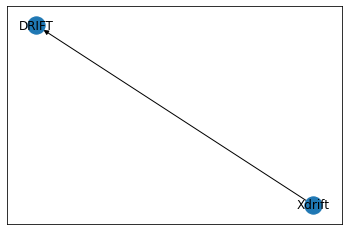

In [4]:
# define the DRIFT, train it before adding it to the network
drift_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, data.Xdrift.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='softplus')
drift_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}

drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[drift_pars])

# Stand-alone drift model
drift_mod = NDN.NDN(ffnet_list=[drift_net], loss_type='poisson')


# Train the DRIFT Model
drift_mod.fit(data, force_dict_training=True, **lbfgs_pars, verbose=0)
# evaluate model using null-adjusted log-likelihood
LLsDrift = drift_mod.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Drift:", np.mean(LLsDrift))

ml.draw_network(drift_mod, names=['DRIFT'])

<Figure size 432x288 with 0 Axes>

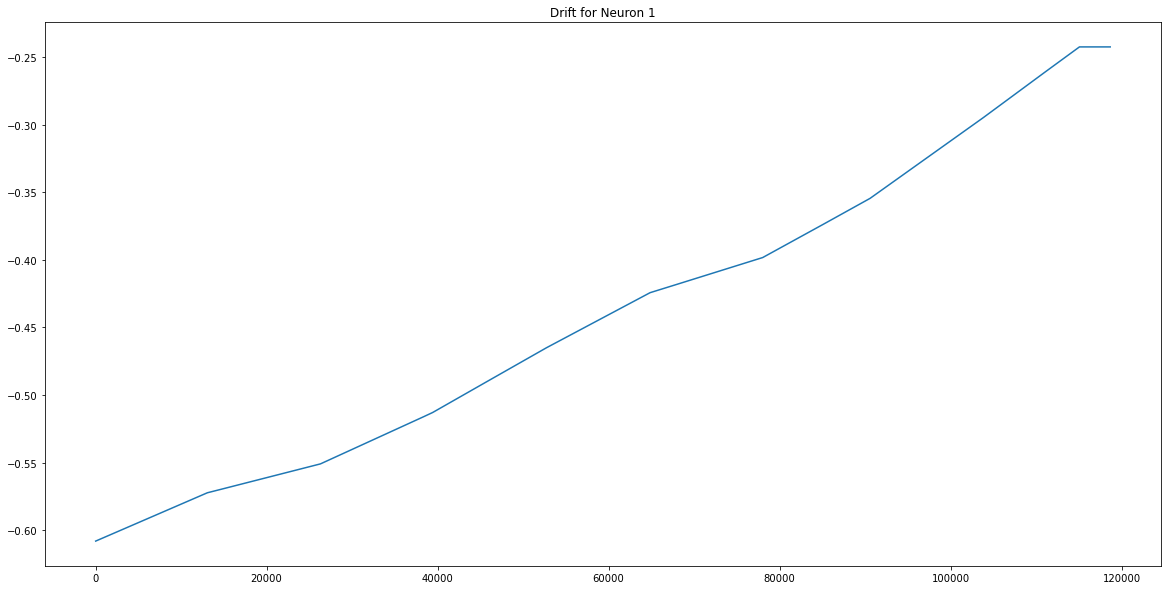

In [5]:
# Check that DRIFT model weights (e.g. predictions), try to make them smoother

# get the weights for the DRIFT network
driftw = drift_mod.networks[0].layers[0].weight.data
data.Xdrift.shape, driftw.shape
# predict the firing rates from the DRIFT
predRs = data.Xdrift @ driftw

m.fig()
plt.plot(predRs[:,0])
plt.title("Drift for Neuron 1")
plt.show()

## Create Xadapt features

<Figure size 432x288 with 0 Axes>

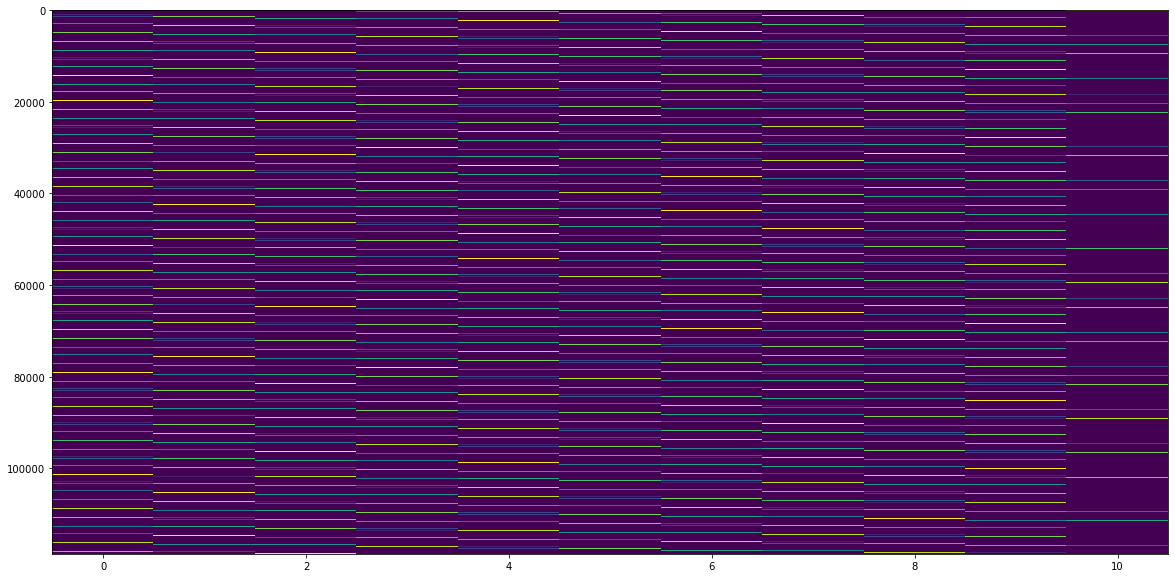

In [6]:
Xadapt = np.zeros((data.NT, 11))
for trial in data.block_inds:
    tents = data.design_matrix_drift(120, [i for i in range(10, 120, 10)])
    # copy this for each trial into the long list of tents
    Xadapt[trial[0]:trial[-1]] = tents[0:trial[-1]-trial[0]]

# this one only populates the first trial with tents,
# we need to populate the rest of the trials with tents
m.fig()
plt.imshow(Xadapt, aspect='auto', interpolation='none')
plt.show()

## Create XadaptCU features

<Figure size 432x288 with 0 Axes>

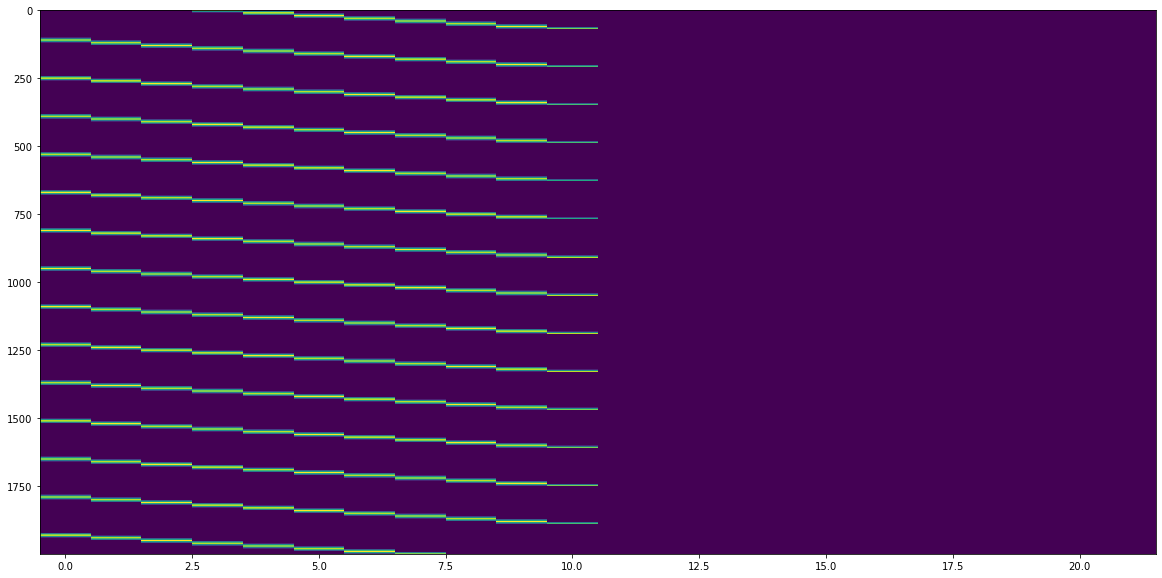

In [7]:
# split Xadapt by cued and uncued trials
trcued = np.where(data.TRcued > 0)[0]
truncued = np.where(data.TRcued < 0)[0]
cued = []
for tr in trcued: cued.extend(data.block_inds[tr])
uncued = []
for tr in truncued: uncued.extend(data.block_inds[tr])

# concatenate these as separate features into a new cued+uncued design matrix
XadaptC = deepcopy(Xadapt)
XadaptU = deepcopy(Xadapt)
XadaptC[uncued] = 0
XadaptU[cued] = 0
XadaptCU = np.array([np.hstack((XadaptC[t,:], XadaptU[t,:])) for t in range(Xadapt.shape[0])])


m.fig()
plt.imshow(XadaptCU[2000:4000], aspect='auto', interpolation='none')
plt.show()

In [8]:
data.TRsignal, data.TRcued

(array([[-1,  1],
        [ 1,  1],
        [ 1, -1],
        ...,
        [ 1, -1],
        [ 1,  1],
        [-1,  1]], dtype=int16),
 array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1,  1,  1,  1,  1, 

## Create strength feature for trials

In [9]:
# create feature (and network) for trials where the signal is strong versus weak
XstrengthC = []
XstrengthU = []
XstrengthCU = []
# copy the strength from the side that is cued for cued trials 
#      and the side that is uncuded for uncued trials
# should I just copy it for every time point? let's try that and see how it works
trcued = deepcopy(data.TRcued)
trcued[np.where(trcued<0)] = 0
# get the strength based on the side that was cued

strength = np.zeros((data.NT, 1))
trstrength = np.zeros((len(trcued), 1))
for tr in range(len(trcued)):
    trstrength[tr] = data.TRstrength[tr, trcued[tr]]
    strength[data.block_inds[tr]] = data.TRstrength[tr, trcued[tr]]

# one-hot encode the strength variable and make a design matrix for another X
strength_cats = np.unique(strength)
strength_onehot = np.zeros((data.NT, 3))
for tr in range(len(trcued)):
    strength_onehot[data.block_inds[tr]] = np.zeros(3)
    onehot = np.where(strength_cats==trstrength[tr])[0][0]
    strength_onehot[data.block_inds[tr], onehot] = 1

# add in the strength into the dataset
data.add_covariate("Xstrength", strength)
data.add_covariate("Xstrength_onehot", strength_onehot)

In [10]:
strength_onehot.shape, strength.shape, strength_cats

((118679, 3), (118679, 1), array([0.  , 0.07, 0.27]))

In [11]:
# TODO: if we fit the model with this as an additional network,
#       what do we get from those weights? Just which kind of strength it was?
#       I guess I don't see what this does for us right now.
#       Maybe there is another way to put task-dependency in the model.

<Figure size 432x288 with 0 Axes>

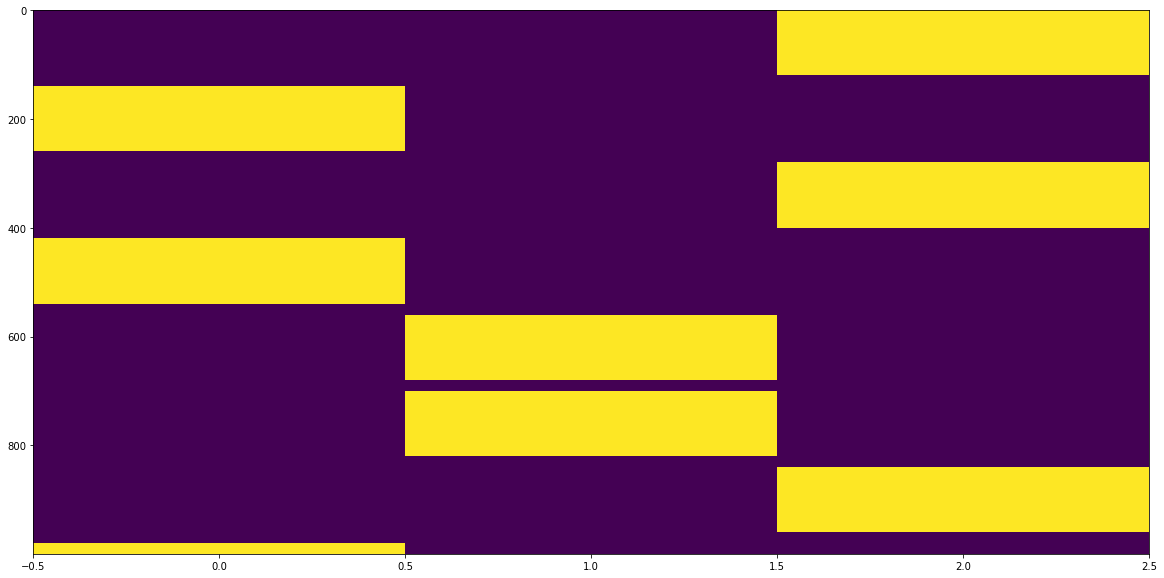

In [12]:
m.fig()
plt.imshow(strength_onehot[:1000], aspect='auto', interpolation='none')
plt.show()

## Create XadaptStrCU features (trial adaptation by strength)

In [13]:
data.TRcued.shape, data.TRstrength.shape, trstrength.shape, np.unique(data.TRstrength), data.TRstrength[0]

((848,), (848, 2), (848, 1), array([0.  , 0.07, 0.27]), array([0.07, 0.27]))

In [14]:
# This feature breaks XadaptCU into trials where strength is 0, 0.07, or 0.27
trcuedstr0 = np.where((data.TRcued > 0) & (trstrength.T == 0.0))[1]
trcuedstr1 = np.where((data.TRcued > 0) & (trstrength.T == 0.07))[1]
trcuedstr2 = np.where((data.TRcued > 0) & (trstrength.T == 0.27))[1]
truncuedstr0 = np.where((data.TRcued < 0) & (trstrength.T == 0.0))[1]
truncuedstr1 = np.where((data.TRcued < 0) & (trstrength.T == 0.07))[1]
truncuedstr2 = np.where((data.TRcued < 0) & (trstrength.T == 0.27))[1]

<Figure size 432x288 with 0 Axes>

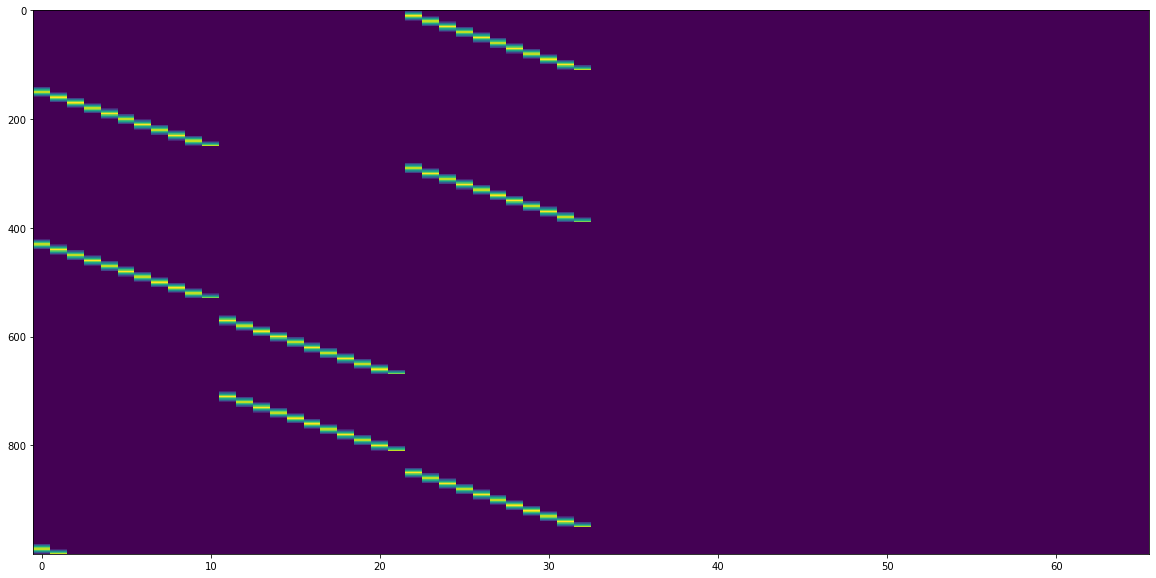

In [15]:
cuedstr0 = []
for tr in trcuedstr0: cuedstr0.extend(data.block_inds[tr])
cuedstr1 = []
for tr in trcuedstr1: cuedstr1.extend(data.block_inds[tr])
cuedstr2 = []
for tr in trcuedstr2: cuedstr2.extend(data.block_inds[tr])
uncuedstr0 = []
for tr in trcuedstr0: cuedstr0.extend(data.block_inds[tr])
uncuedstr1 = []
for tr in trcuedstr1: cuedstr1.extend(data.block_inds[tr])
uncuedstr2 = []
for tr in trcuedstr2: cuedstr2.extend(data.block_inds[tr])


# concatenate these as separate features into a new cued+uncued design matrix
XadaptCS0 = np.zeros(Xadapt.shape)
XadaptCS1 = np.zeros(Xadapt.shape)
XadaptCS2 = np.zeros(Xadapt.shape)
XadaptUS0 = np.zeros(Xadapt.shape)
XadaptUS1 = np.zeros(Xadapt.shape)
XadaptUS2 = np.zeros(Xadapt.shape)

XadaptCS0[cuedstr0] = Xadapt[cuedstr0]
XadaptCS1[cuedstr1] = Xadapt[cuedstr1]
XadaptCS2[cuedstr2] = Xadapt[cuedstr2]
XadaptUS0[uncuedstr0] = Xadapt[uncuedstr0]
XadaptUS1[uncuedstr1] = Xadapt[uncuedstr1]
XadaptUS2[uncuedstr2] = Xadapt[uncuedstr2]

XadaptCUS = np.array([np.hstack((XadaptCS0[t,:],
                                 XadaptCS1[t,:],
                                 XadaptCS2[t,:],
                                 XadaptUS0[t,:],
                                 XadaptUS1[t,:],
                                 XadaptUS2[t,:])) for t in range(Xadapt.shape[0])])

data.add_covariate("XadaptCUS", XadaptCUS)

m.fig()
plt.imshow(XadaptCUS[:1000], aspect='auto', interpolation='none')
plt.show()

## Create XadaptDistCU features (trial adaptation by distance) 

In [16]:
data.TRsignal # L/R N/F (left/right near/far)

array([[-1,  1],
       [ 1,  1],
       [ 1, -1],
       ...,
       [ 1, -1],
       [ 1,  1],
       [-1,  1]], dtype=int16)

<Figure size 432x288 with 0 Axes>

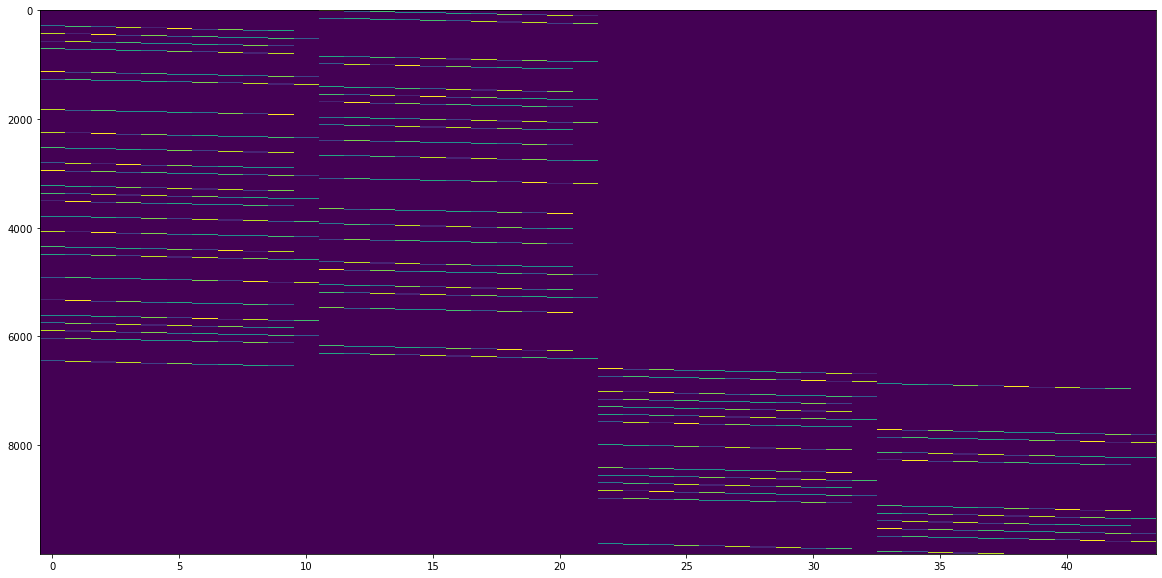

In [17]:
trcued = deepcopy(data.TRcued)
trcued[np.where(trcued<0)] = 0
# get the strength based on the side that was cued

signal = np.zeros((data.NT, 1))
trsignal = np.zeros((len(trcued), 1))
for tr in range(len(trcued)):
    trsignal[tr] = data.TRsignal[tr, trcued[tr]]
    signal[data.block_inds[tr]] = data.TRsignal[tr, trcued[tr]]

# This feature breaks XadaptCU into trials where signal for cued side is near or far
trcuednear = np.where((data.TRcued > 0) & (trsignal.T == -1))[1]
trcuedfar = np.where((data.TRcued > 0) & (trsignal.T == 1))[1]
truncuednear = np.where((data.TRcued < 0) & (trsignal.T == -1))[1]
truncuedfar = np.where((data.TRcued < 0) & (trsignal.T == 1))[1]


cuednear = []
for tr in trcuednear: cuednear.extend(data.block_inds[tr])
cuedfar = []
for tr in trcuedfar: cuedfar.extend(data.block_inds[tr])
uncuednear = []
for tr in truncuednear: uncuednear.extend(data.block_inds[tr])
uncuedfar = []
for tr in truncuedfar: uncuedfar.extend(data.block_inds[tr])


# concatenate these as separate features into a new cued+uncued design matrix
XadaptCN = np.zeros(Xadapt.shape)
XadaptCF = np.zeros(Xadapt.shape)
XadaptUN = np.zeros(Xadapt.shape)
XadaptUF = np.zeros(Xadapt.shape)

XadaptCN[cuednear] = Xadapt[cuednear]
XadaptCF[cuedfar] = Xadapt[cuedfar]
XadaptUN[uncuednear] = Xadapt[uncuednear]
XadaptUF[uncuedfar] = Xadapt[uncuedfar]

XadaptCUDIST = np.array([np.hstack((XadaptCN[t,:],
                                    XadaptCF[t,:],
                                    XadaptUN[t,:],
                                    XadaptUF[t,:])) for t in range(Xadapt.shape[0])])

data.add_covariate("XadaptCUDIST", XadaptCUDIST)

m.fig()
plt.imshow(XadaptCUDIST[:10000], aspect='auto', interpolation='none')
plt.show()

## Train ADAPT Model

Mean LL-Adapt: -0.21236362


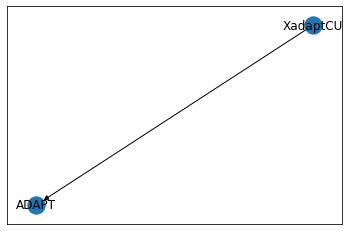

In [18]:
data.add_covariate('Xadapt', Xadapt)
data.add_covariate('XadaptCU', XadaptCU)

# define the ADAPT, train it before adding it to the network
adapt_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, XadaptCU.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='softplus')
adapt_pars['reg_vals'] = {'d2t': 0.2, 'bcs': {'d2t': 0}}

adapt_net = FFnetwork.ffnet_dict(xstim_n='XadaptCU', layer_list=[adapt_pars])

# Stand-alone drift model
adapt_mod = NDN.NDN(ffnet_list=[adapt_net], loss_type='poisson')

# Train the ADAPT model
adapt_mod.fit(data, force_dict_training=True, **lbfgs_pars, verbose=0)
# evaluate model using null-adjusted log-likelihood
LLsAdapt = adapt_mod.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Adapt:", np.mean(LLsDrift - LLsAdapt))

ml.draw_network(adapt_mod, names=['ADAPT'])


<Figure size 432x288 with 0 Axes>

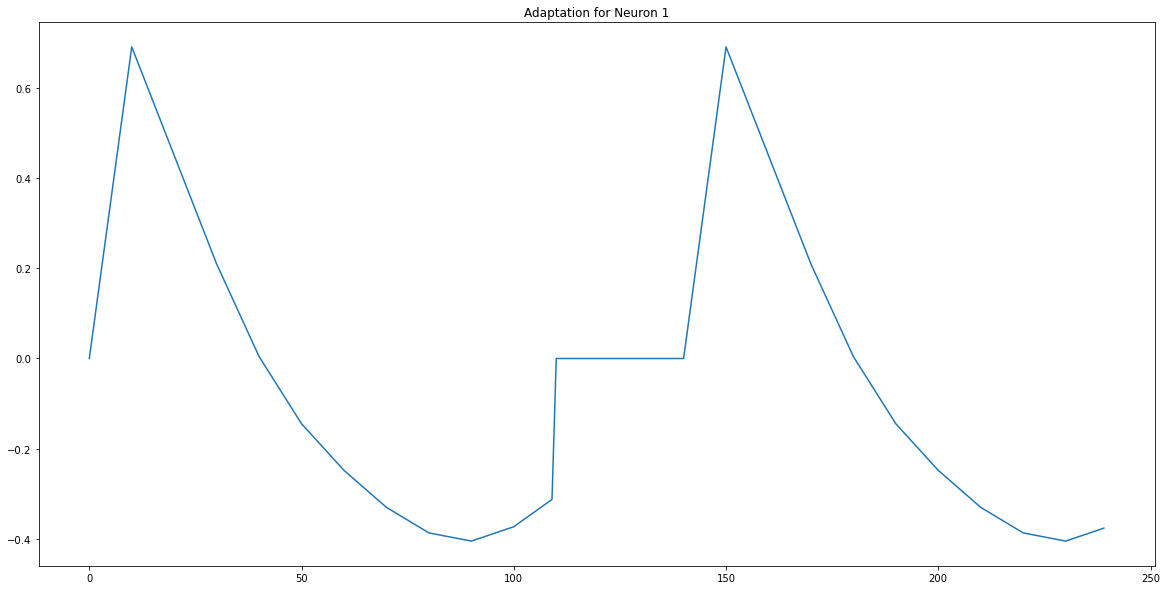

In [19]:
# Check that ADAPT model weights (e.g. predictions), try to make them smoother

# get the weights for the ADAPT network
adaptw = adapt_mod.networks[0].layers[0].weight.data

# predict the firing rates from the DRIFT
predRs = torch.tensor(XadaptCU, dtype=torch.float) @ adaptw

m.fig()
plt.plot(predRs[:,0][:240])
plt.title("Adaptation for Neuron 1")
plt.show()

## Train STIM Model

Mean LLsGLM: 0.04776536


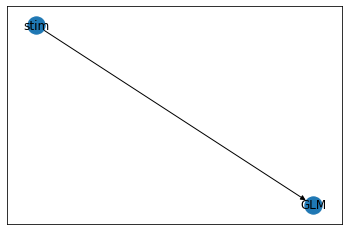

In [20]:
# define the GLM, train it before adding it to the network
stim_layer = NDNLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=data.NC,
    bias=True,
    initialize_center=True,
    NLtype='softplus') # use linear output since it is a layer of the larger model

# regularization method (use d2xt with lambda weight 0.02)
stim_layer['reg_vals'] = {'d2xt': 0.2, 'bcs':{'d2xt': 1}}

# only return the FFnetwork wrapped NDNLayer when combining this with other layers
stim_network = FFnetwork.ffnet_dict(xstim_n='stim', layer_list=[stim_layer])

stim_mod = NDN.NDN(ffnet_list=[stim_network], loss_type='poisson')

# Train the STIM model
stim_mod.fit(data, force_dict_training=True, **lbfgs_pars, verbose=0)
LLsGLM = stim_mod.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LLsGLM:", np.mean(LLsDrift - LLsGLM))


ml.draw_network(stim_mod, names=['GLM'])

## Create the smoothed_robs features

In [21]:
# add the smoothed robs into the model as a covariate
sm_robs100 = lv.smooth(data.robs, n=100)
data.add_covariate('smoothed_robs', sm_robs100)
sm_robs100.shape, data.stim_dims

((118679, 31), [1, 11, 1, 12])

# ADAPTATION

In [22]:
# TODO move the relevant stuff here, and for each other section
# TODO: also move the feature creation here, and for each other section

## train the model

Model: M031_N_N_N_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.240277051925659 sec elapsed
Mean LL-Adapt: 0.07794757


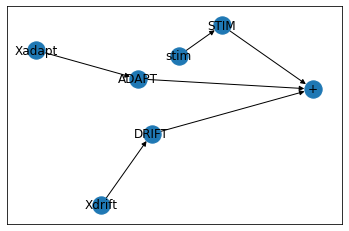

In [23]:
# define the DRIFT network
drift_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, data.Xdrift.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0, # Q: what norm type is this and why should we use it?
    NLtype='lin')
drift_pars['reg_vals'] = {'d2t': 0.2, 'bcs': {'d2t': 0}}
drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[drift_pars])


# define the ADAPT network
adapt_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, Xadapt.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='lin')
adapt_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}
adapt_net = FFnetwork.ffnet_dict(xstim_n='Xadapt', layer_list=[adapt_pars])


# define the STIM network
stim_layer = NDNLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=data.NC,
    bias=False,
    initialize_center=True,
    NLtype='lin')
stim_layer['reg_vals'] = {'d2xt': 0.2, 'bcs':{'d2xt': 1}}
stim_net = FFnetwork.ffnet_dict(xstim_n='stim', layer_list=[stim_layer])


# define the COMBINE network
comb_layer = ChannelLayer.layer_dict(
    num_filters=data.NC,
    NLtype='softplus',
    bias=True)
comb_layer['weights_initializer'] = 'ones'
comb_net = FFnetwork.ffnet_dict(xstim_n=None, ffnet_n=[0, 1, 2], layer_list=[comb_layer], ffnet_type='add')

# define the COMPLETE model
model = NDN.NDN(ffnet_list=[drift_net, adapt_net, stim_net, comb_net], loss_type='poisson')

# copy the fit drift weights into this network and freeze them
model.networks[0].layers[0].weight.data = deepcopy(driftw)
model.set_parameters(val=False, name='weight', ffnet_target=0)

# Draw the network
ml.draw_network(model, ['DRIFT', 'ADAPT', 'STIM','+'] )

# Train the complete model
# it automatically uses the train_inds specified in the Dataset object when calling fit()
model.fit(data, force_dict_training=True, **lbfgs_pars, verbose=1)
# evaluate the model
LLsALL = model.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Adapt:", np.mean(LLsDrift - LLsALL))

## look at the weights

<Figure size 432x288 with 0 Axes>

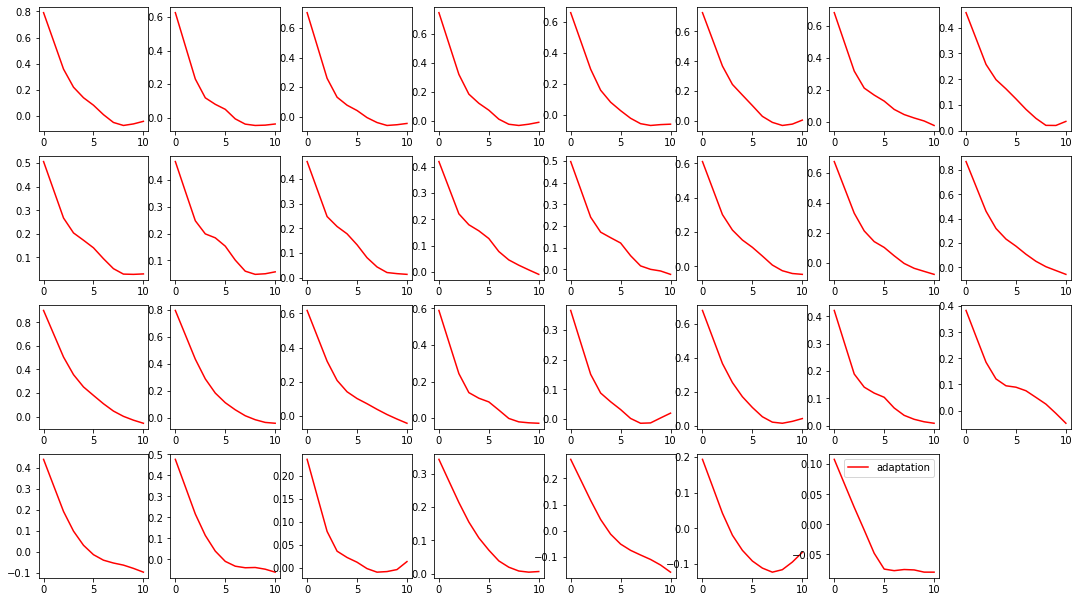

In [24]:
# compare XadaptU with XadaptC weights after fitting the model
fig = m.fig()
fig.set_size_inches(18.5, 10.5)
for c in range(data.NC):
    plt.subplot(4,8, c+1)
    plt.plot(model.networks[1].layers[0].weight.data[range(0,11), c], 'r', label='adaptation')
plt.legend()
plt.show()

# I believe this is telling us how much adaptation there is when the monkey is
# paying attention vs. not paying attention.
# It kind of looks like, when they are cued, they respond a lot at the beginning
# and then stop.
# -- talked with Dan, and he agreed with this interpretation.

# CUEDvUNCUED+ADAPTION

## train the model

Model: M031_N_N_N_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.4983742237091064 sec elapsed
Mean LL-Adapt: 0.10480104


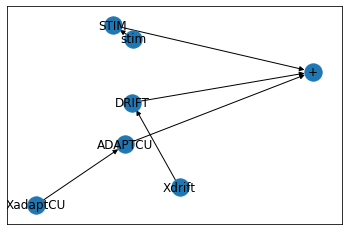

In [25]:
# define the DRIFT network
drift_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, data.Xdrift.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0, # Q: what norm type is this and why should we use it?
    NLtype='lin')
drift_pars['reg_vals'] = {'d2t': 0.2, 'bcs': {'d2t': 0}}
drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[drift_pars])


# define the ADAPT network
adaptcu_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, XadaptCU.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='lin')
adaptcu_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}
adaptcu_net = FFnetwork.ffnet_dict(xstim_n='XadaptCU', layer_list=[adaptcu_pars])


# define the STIM network
stim_layer = NDNLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=data.NC,
    bias=False,
    initialize_center=True,
    NLtype='lin')
stim_layer['reg_vals'] = {'d2xt': 0.2, 'bcs':{'d2xt': 1}}
stim_net = FFnetwork.ffnet_dict(xstim_n='stim', layer_list=[stim_layer])


# define the COMBINE network
comb_layer = ChannelLayer.layer_dict(
    num_filters=data.NC,
    NLtype='softplus',
    bias=True)
comb_layer['weights_initializer'] = 'ones'
comb_net = FFnetwork.ffnet_dict(xstim_n=None, ffnet_n=[0, 1, 2], layer_list=[comb_layer], ffnet_type='add')

# define the COMPLETE model
model = NDN.NDN(ffnet_list=[drift_net, adaptcu_net, stim_net, comb_net], loss_type='poisson')

# copy the fit drift weights into this network and freeze them
model.networks[0].layers[0].weight.data = deepcopy(driftw)
model.set_parameters(val=False, name='weight', ffnet_target=0)

# Draw the network
ml.draw_network(model, ['DRIFT', 'ADAPTCU', 'STIM','+'] )

# Train the complete model
# it automatically uses the train_inds specified in the Dataset object when calling fit()
model.fit(data, force_dict_training=True, **lbfgs_pars, verbose=1)
# evaluate the model
LLsALL = model.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Adapt:", np.mean(LLsDrift - LLsALL))

## look at the weights

<Figure size 432x288 with 0 Axes>

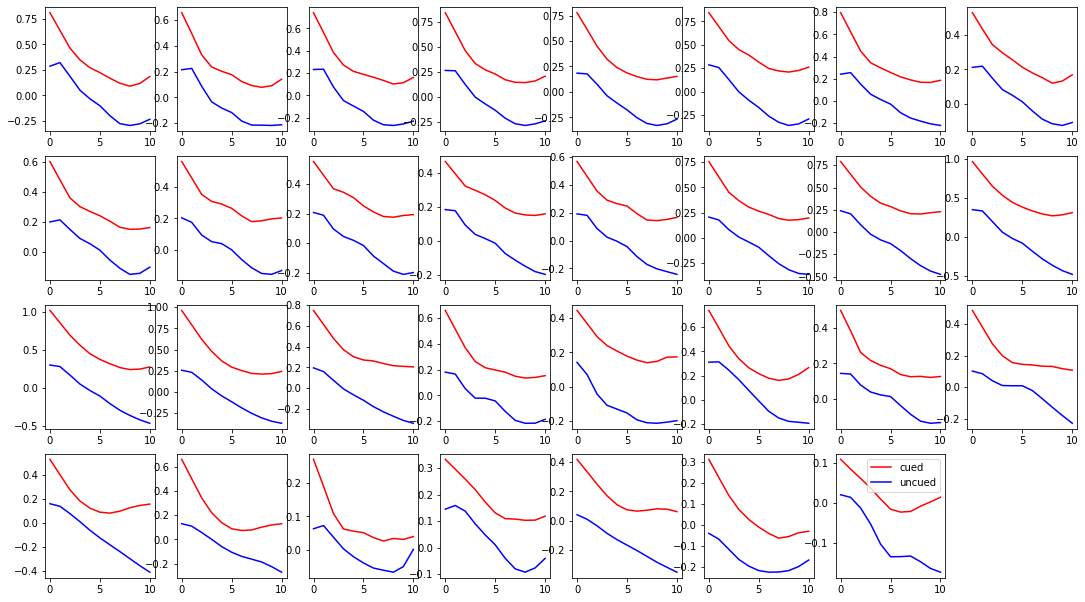

In [26]:
# compare XadaptU with XadaptC weights after fitting the model
fig = m.fig()
fig.set_size_inches(18.5, 10.5)
for c in range(data.NC):
    plt.subplot(4,8, c+1)
    plt.plot(model.networks[1].layers[0].weight.data[range(0,11), c], 'r', label='cued')
    plt.plot(model.networks[1].layers[0].weight.data[range(11,22), c], 'b', label='uncued')
plt.legend()
plt.show()

# I believe this is telling us how much adaptation there is when the monkey is
# paying attention vs. not paying attention.
# It kind of looks like, when they are cued, they respond a lot at the beginning
# and then stop.
# -- talked with Dan, and he agreed with this interpretation.

# CUEDvUNCUED PSTH

<Figure size 432x288 with 0 Axes>

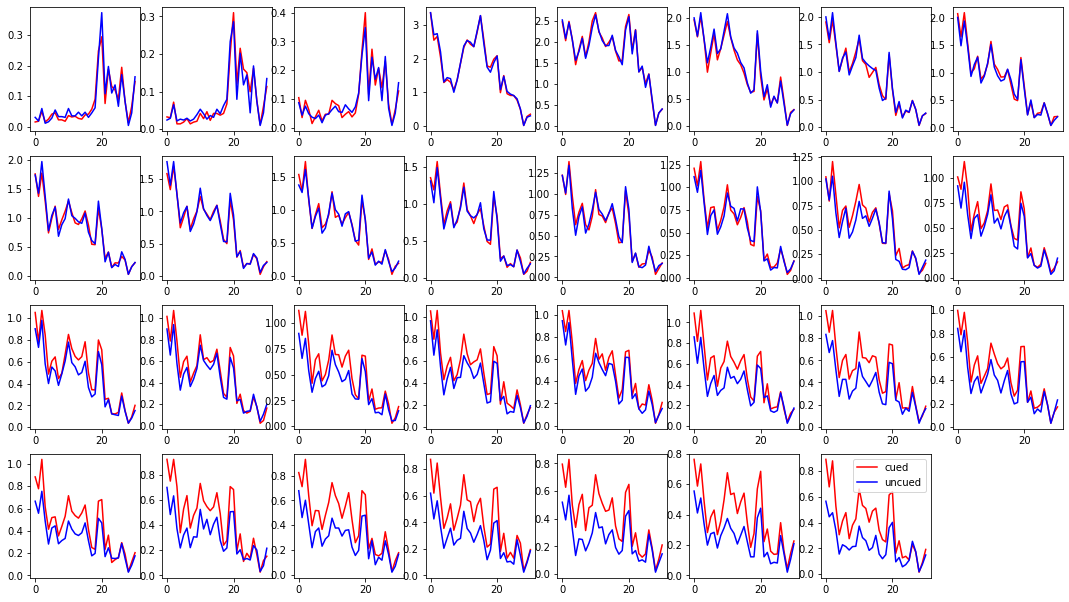

In [27]:
# average responses per neuron over trials, separated out for cued and uncued trials
# separate out robs into trials
min_trial_length = min([len(data.robs[trial]) for trial in data.block_inds])
trrobs = np.zeros((31, len(data.block_inds), min_trial_length))
for cell in range(data.NC):
    for trnum, trial in enumerate(data.block_inds):
        trrobs[cell, trnum, :] = data.robs[trial[0]:trial[0]+min_trial_length, cell]

# split by cued and uncued trials
trcued = np.where(data.TRcued > 0)[0]
truncued = np.where(data.TRcued < 0)[0]

trrobs_cued = trrobs[:, trcued, :]
trrobs_uncued = trrobs[:, truncued, :]

# average cells over trials
trrobs_cued_mean = np.mean(trrobs_cued, axis=1)
trrobs_uncued_mean = np.mean(trrobs_uncued, axis=1)

# plot the PSTH for each cell
fig = m.fig()
fig.set_size_inches(18.5, 10.5)
for c in range(data.NC):
    plt.subplot(4,8, c+1)
    plt.plot(trrobs_cued_mean[:, c], 'red', label='cued')
    plt.plot(trrobs_uncued_mean[:, c], 'blue', label='uncued')
plt.legend()
plt.show()

# QUESTION: this doesn't look completely like the model, is this due to not including the other features?
#           even the model without the other features doesn't really look like this... 

# CUEDvUNCUED ONLY IN MODEL

Model: M031_N_N_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 0.35065317153930664 sec elapsed
Mean LL-Adapt: 0.041774176


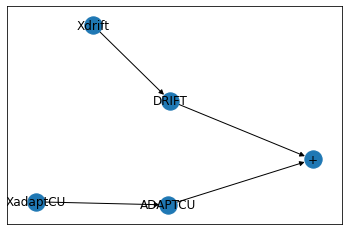

In [28]:
# define the DRIFT network
drift_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, data.Xdrift.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0, # Q: what norm type is this and why should we use it?
    NLtype='lin')
drift_pars['reg_vals'] = {'d2t': 0.2, 'bcs': {'d2t': 0}}
drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[drift_pars])


# define the ADAPT network
adaptcu_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, XadaptCU.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='lin')
adaptcu_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}
adaptcu_net = FFnetwork.ffnet_dict(xstim_n='XadaptCU', layer_list=[adaptcu_pars])


# define the COMBINE network
comb_layer = ChannelLayer.layer_dict(
    num_filters=data.NC,
    NLtype='softplus',
    bias=True)
comb_layer['weights_initializer'] = 'ones'
comb_net = FFnetwork.ffnet_dict(xstim_n=None, ffnet_n=[0, 1], layer_list=[comb_layer], ffnet_type='add')

# define the COMPLETE model
model = NDN.NDN(ffnet_list=[drift_net, adaptcu_net, comb_net], loss_type='poisson')

# copy the fit drift weights into this network and freeze them
model.networks[0].layers[0].weight.data = deepcopy(driftw)
model.set_parameters(val=False, name='weight', ffnet_target=0)

# Draw the network
ml.draw_network(model, ['DRIFT', 'ADAPTCU', '+'] )

# Train the complete model
# it automatically uses the train_inds specified in the Dataset object when calling fit()
model.fit(data, force_dict_training=True, **lbfgs_pars, verbose=1)
# evaluate the model
LLsALL = model.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Adapt:", np.mean(LLsDrift - LLsALL))

<Figure size 432x288 with 0 Axes>

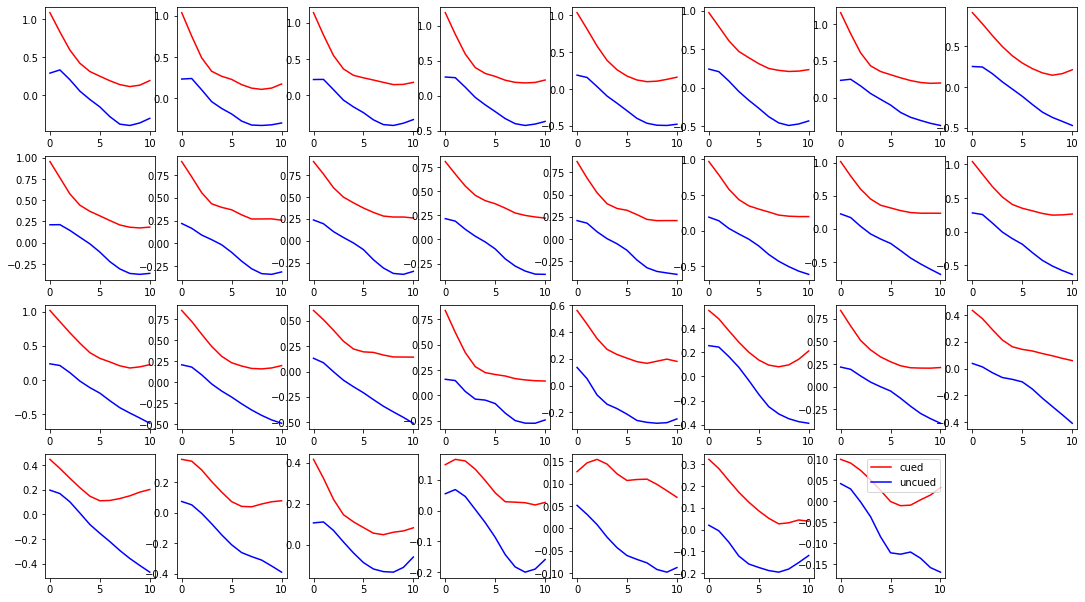

<Figure size 432x288 with 0 Axes>

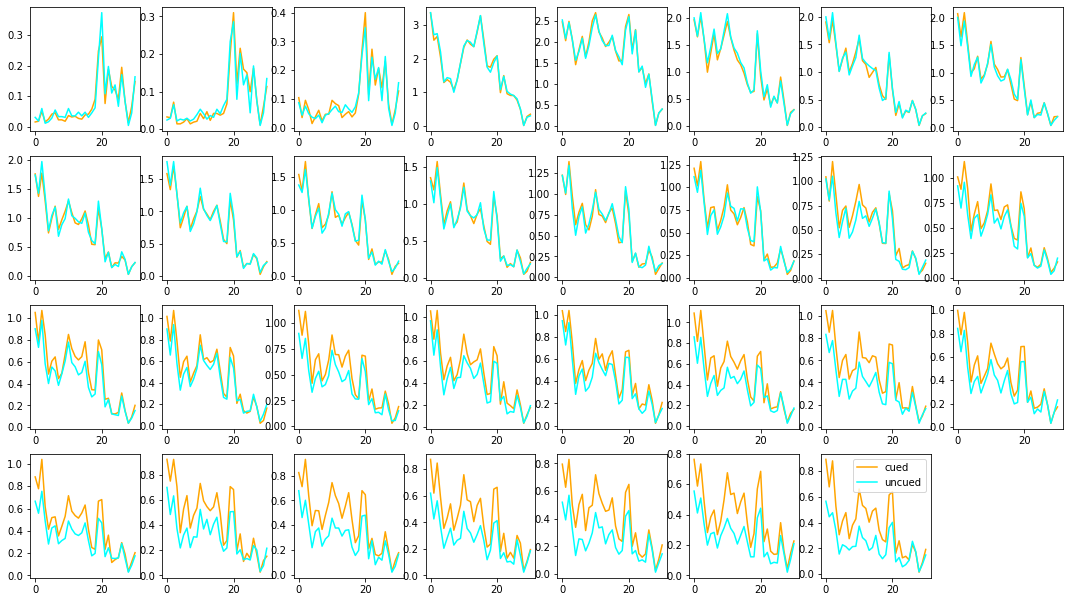

In [29]:
fig = m.fig()
fig.set_size_inches(18.5, 10.5)
for c in range(data.NC):
    plt.subplot(4,8, c+1)
    plt.plot(model.networks[1].layers[0].weight.data[range(0,11), c], 'red', label='cued')
    plt.plot(model.networks[1].layers[0].weight.data[range(11,22), c], 'blue', label='uncued')
plt.legend()
plt.show()

fig = m.fig()
fig.set_size_inches(18.5, 10.5)
for c in range(data.NC):
    plt.subplot(4, 8, c + 1)
    plt.plot(trrobs_cued_mean[:, c], 'orange', label='cued')
    plt.plot(trrobs_uncued_mean[:, c], 'cyan', label='uncued')
plt.legend()
plt.show()

So... these don't look that similar, is there something wrong with my PSTH?
Or... is there something off with my other model?

# CUEDvUNCUED+STRENGTH

## train the model

Model: M031_N_N_N_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.011456489562988 sec elapsed
Mean LL-Adapt: 0.094115


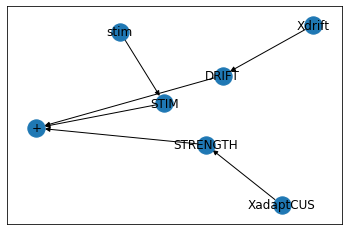

In [30]:
# define the DRIFT network
drift_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, data.Xdrift.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0, # Q: what norm type is this and why should we use it?
    NLtype='lin')
drift_pars['reg_vals'] = {'d2t': 0.2, 'bcs': {'d2t': 0}}
drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[drift_pars])


# define the ADAPT network
adapt_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, XadaptCU.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='lin')
adapt_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}
adapt_net = FFnetwork.ffnet_dict(xstim_n='XadaptCU', layer_list=[adapt_pars])


# define the STRENGTH network
strength_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, XadaptCUS.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='lin')
strength_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}
strength_net = FFnetwork.ffnet_dict(xstim_n='XadaptCUS', layer_list=[strength_pars])


# define the STIM network
stim_layer = NDNLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=data.NC,
    bias=False,
    initialize_center=True,
    NLtype='lin')
stim_layer['reg_vals'] = {'d2xt': 0.2, 'bcs':{'d2xt': 1}}
stim_net = FFnetwork.ffnet_dict(xstim_n='stim', layer_list=[stim_layer])


# define the COMBINE network
comb_layer = ChannelLayer.layer_dict(
    num_filters=data.NC,
    NLtype='softplus',
    bias=True)
comb_layer['weights_initializer'] = 'ones'
comb_net = FFnetwork.ffnet_dict(xstim_n=None, ffnet_n=[0, 1, 2], layer_list=[comb_layer], ffnet_type='add')

# define the COMPLETE model
model = NDN.NDN(ffnet_list=[drift_net, strength_net, stim_net, comb_net], loss_type='poisson')

# copy the fit drift weights into this network and freeze them
model.networks[0].layers[0].weight.data = deepcopy(driftw)
model.set_parameters(val=False, name='weight', ffnet_target=0)

# Draw the network
ml.draw_network(model, ['DRIFT', 'STRENGTH', 'STIM','+'] )

# Train the complete model
# it automatically uses the train_inds specified in the Dataset object when calling fit()
model.fit(data, force_dict_training=True, **lbfgs_pars, verbose=1)
# Evaluate the model
LLsALL = model.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Adapt:", np.mean(LLsDrift - LLsALL))

## look at weights 

<Figure size 432x288 with 0 Axes>

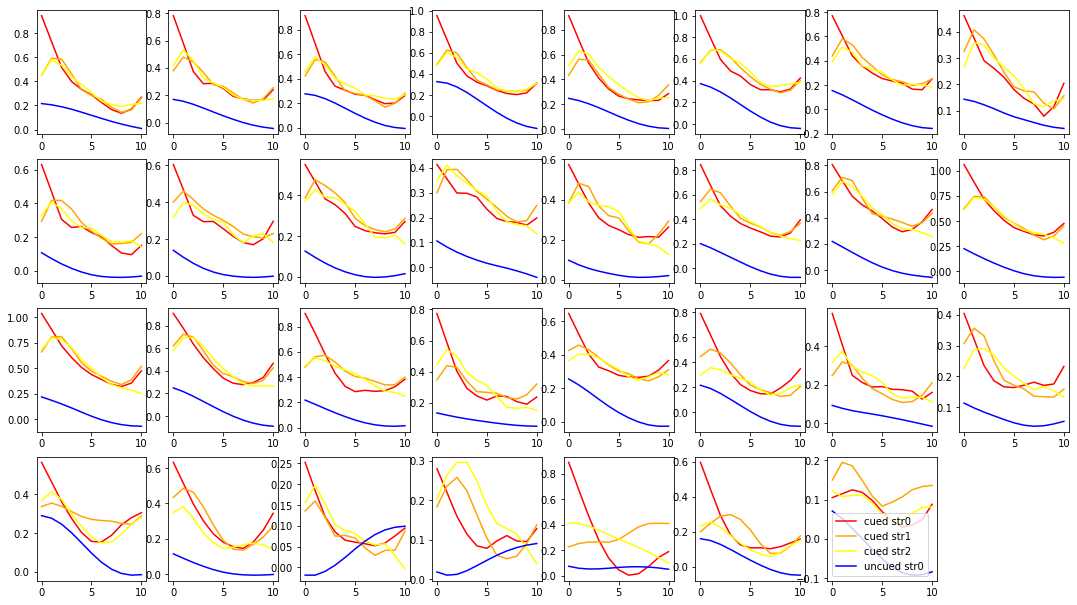

<Figure size 432x288 with 0 Axes>

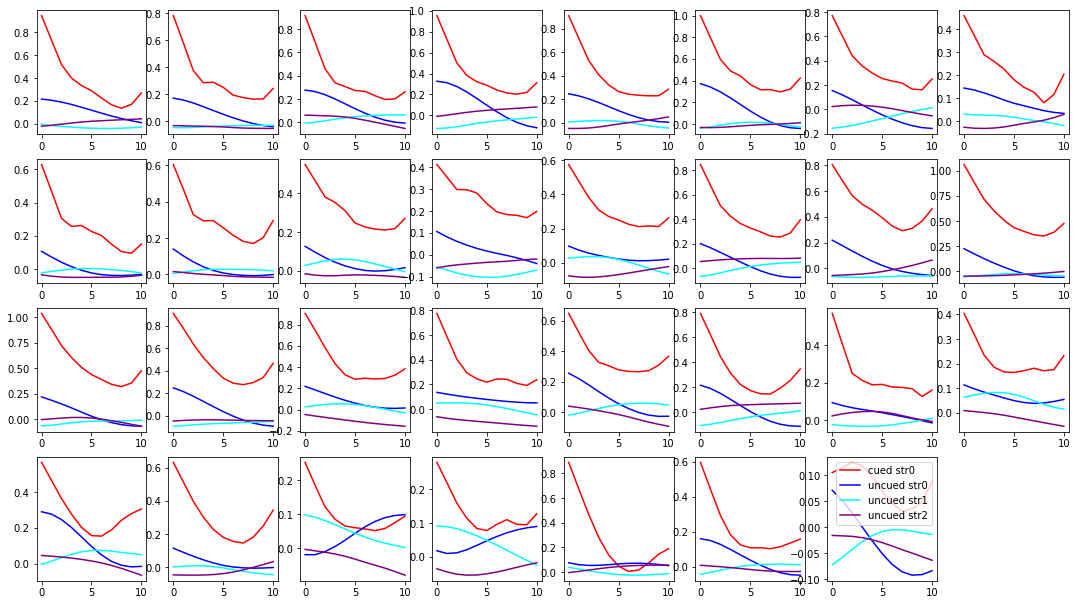

In [31]:
fig = m.fig()
fig.set_size_inches(18.5, 10.5)
for c in range(data.NC):
    plt.subplot(4,8, c+1)
    plt.plot(model.networks[1].layers[0].weight.data[range(0,11), c], 'red', label='cued str0')
    plt.plot(model.networks[1].layers[0].weight.data[range(11,22), c], 'orange', label='cued str1')
    plt.plot(model.networks[1].layers[0].weight.data[range(22,33), c], 'yellow', label='cued str2')
    plt.plot(model.networks[1].layers[0].weight.data[range(33,44), c], 'blue', label='uncued str0')
plt.legend()
plt.show()

fig = m.fig()
fig.set_size_inches(18.5, 10.5)
for c in range(data.NC):
    plt.subplot(4,8, c+1)
    plt.plot(model.networks[1].layers[0].weight.data[range(0,11), c], 'red', label='cued str0')
    plt.plot(model.networks[1].layers[0].weight.data[range(33,44), c], 'blue', label='uncued str0')
    plt.plot(model.networks[1].layers[0].weight.data[range(44,55), c], 'cyan', label='uncued str1')
    plt.plot(model.networks[1].layers[0].weight.data[range(55,66), c], 'purple', label='uncued str2')
plt.legend()
plt.show()

# CUEDvUNCUED+DISTANCE

## train the model

Model: M031_N_N_N_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.6285958290100098 sec elapsed
Mean LL-Adapt: 0.103232235


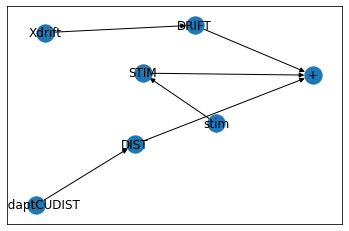

In [32]:
# define the DRIFT network
drift_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, data.Xdrift.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0, # Q: what norm type is this and why should we use it?
    NLtype='lin')
drift_pars['reg_vals'] = {'d2t': 0.2, 'bcs': {'d2t': 0}}
drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[drift_pars])


# define the DIST network
distance_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, XadaptCUDIST.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='lin')
distance_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}
distance_net = FFnetwork.ffnet_dict(xstim_n='XadaptCUDIST', layer_list=[distance_pars])


# define the STIM network
stim_layer = NDNLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=data.NC,
    bias=False,
    initialize_center=True,
    NLtype='lin')
stim_layer['reg_vals'] = {'d2xt': 0.2, 'bcs':{'d2xt': 1}}
stim_net = FFnetwork.ffnet_dict(xstim_n='stim', layer_list=[stim_layer])


# define the COMBINE network
comb_layer = ChannelLayer.layer_dict(
    num_filters=data.NC,
    NLtype='softplus',
    bias=True)
comb_layer['weights_initializer'] = 'ones'
comb_net = FFnetwork.ffnet_dict(xstim_n=None, ffnet_n=[0, 1, 2], layer_list=[comb_layer], ffnet_type='add')


# define the COMPLETE model
model = NDN.NDN(ffnet_list=[drift_net, distance_net, stim_net, comb_net], loss_type='poisson')


# copy the fit drift weights into this network and freeze them
model.networks[0].layers[0].weight.data = deepcopy(driftw)
model.set_parameters(val=False, name='weight', ffnet_target=0)


# Draw the network
ml.draw_network(model, ['DRIFT', 'DIST', 'STIM','+'] )


# Train the complete model
# it automatically uses the train_inds specified in the Dataset object when calling fit()
model.fit(data, force_dict_training=True, **lbfgs_pars, verbose=1)
# Evaluate the complete model
LLsALL = model.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Adapt:", np.mean(LLsDrift - LLsALL))

## look at the weights

<Figure size 432x288 with 0 Axes>

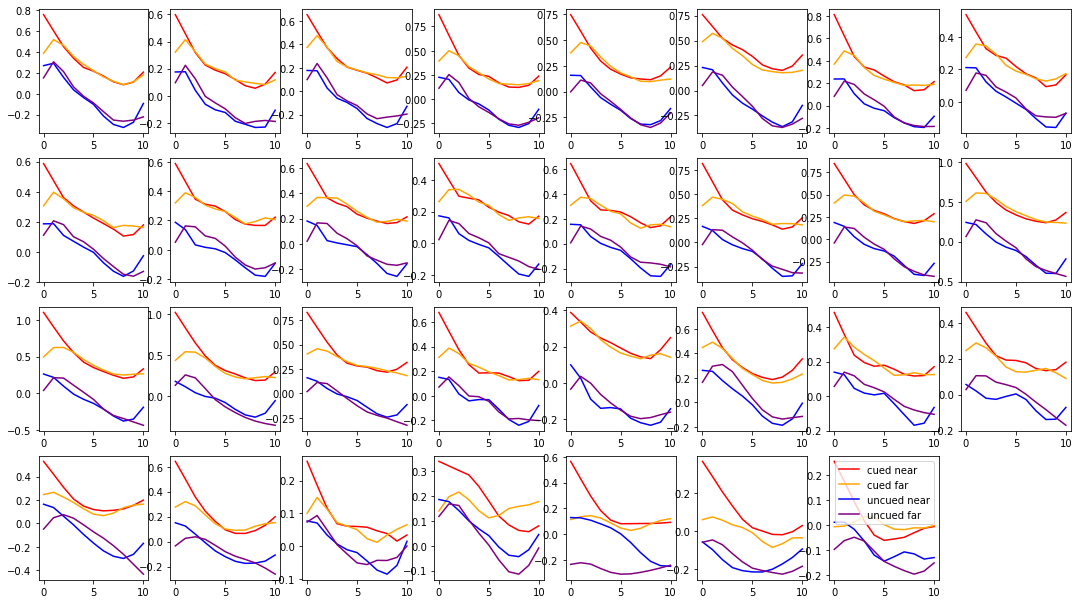

In [33]:
fig = m.fig()
fig.set_size_inches(18.5, 10.5)
for c in range(data.NC):
    plt.subplot(4,8, c+1)
    plt.plot(model.networks[1].layers[0].weight.data[range(0,11), c], 'red', label='cued near')
    plt.plot(model.networks[1].layers[0].weight.data[range(11,22), c], 'orange', label='cued far')
    plt.plot(model.networks[1].layers[0].weight.data[range(22,33), c], 'blue', label='uncued near')
    plt.plot(model.networks[1].layers[0].weight.data[range(33,44), c], 'purple', label='uncued far')
plt.legend()
plt.show()

# CORRECTvINCORRECT

## psychophysics

In [34]:
stim_to_correct = {}
for sig, strength, side, choice in zip(data.TRsignal, data.TRstrength, data.TRcued, data.TRchoice):
    if side < 0: side = 0 # make -1 sides into 0 for indexing purposes
    side = 1 - side

    stim = sig[side]*strength[side] # stimulus is signal (-1 or +1) times it strength

    if stim not in stim_to_correct: stim_to_correct[stim] = [] # initialize if not created

    '''sig[side]*choice'''
    if choice > 0: # choice and signal have the same sign
        stim_to_correct[stim].append(1)
    else: # choice and signal have different signs
        stim_to_correct[stim].append(0)


In [35]:
sides = data.TRcued.copy() # copy the array so we don't corrupt the raw data
sides[sides == 1] = 0 # make all +1 sides index into column 0
sides[sides == -1] = 1 # make all the -1 sides index into column 1
# create the array of stims which are the signal*strength at the given cued side
X = [sig[side]*strength[side] for sig, side, strength in zip(data.TRsignal, sides, data.TRstrength)]

# copy the array so we don't corrupt the raw data
Y = data.TRchoice.copy()
#  replace all -1 with 0 to make our choice counts easy to calculate by averaging
Y[Y == -1] = 0

stims = np.unique(X) # get the unique stimulus values
# get the mean choices for each unique stimulus value
responses = [Y[np.where(X == stim)].mean() for stim in stims]
list(zip(stims, responses)) # print this out for reference


[(-0.27, 0.006993006993006993),
 (-0.07, 0.17557251908396945),
 (0.0, 0.5607142857142857),
 (0.07, 0.7445255474452555),
 (0.27, 0.9426751592356688)]

<Figure size 432x288 with 0 Axes>

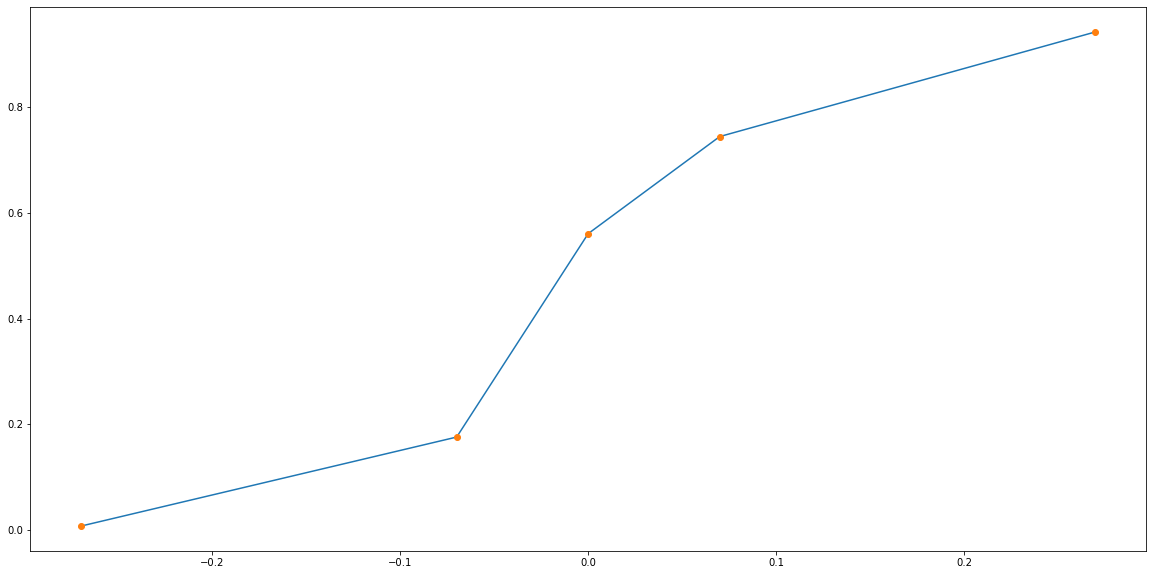

In [36]:
m.fig()
plt.plot(stims, responses)
plt.plot(stims, responses, 'o')
plt.show()

## create the correct feature

In [37]:
# trials where the monkey answered correctly and where the monkey did not
trcorinc = np.zeros((848))
i = 0
for sig, strength, side, choice in zip(data.TRsignal, data.TRstrength, data.TRcued, data.TRchoice):
    # make -1 sides into 0 for indexing purposes (side index = sidx)
    if side < 0: 
        sidx = 0
    else:
        sidx = 1
    sidx = 1 - sidx

    stim = sig[sidx]*strength[sidx] # stimulus is signal (-1 or +1) times it strength

    # only count the trial if there was signal, not zero strength signal
    if strength[sidx] > 0:
        # TODO: double check with Dan that this is the right way to determine correctness
        if choice == side: # choice and signal have the same sign
            trcorinc[i] = 1
        if choice != side: # choice and signal have the same sign
            trcorinc[i] = -1
    
    i += 1

len(trcorinc)

848

<Figure size 432x288 with 0 Axes>

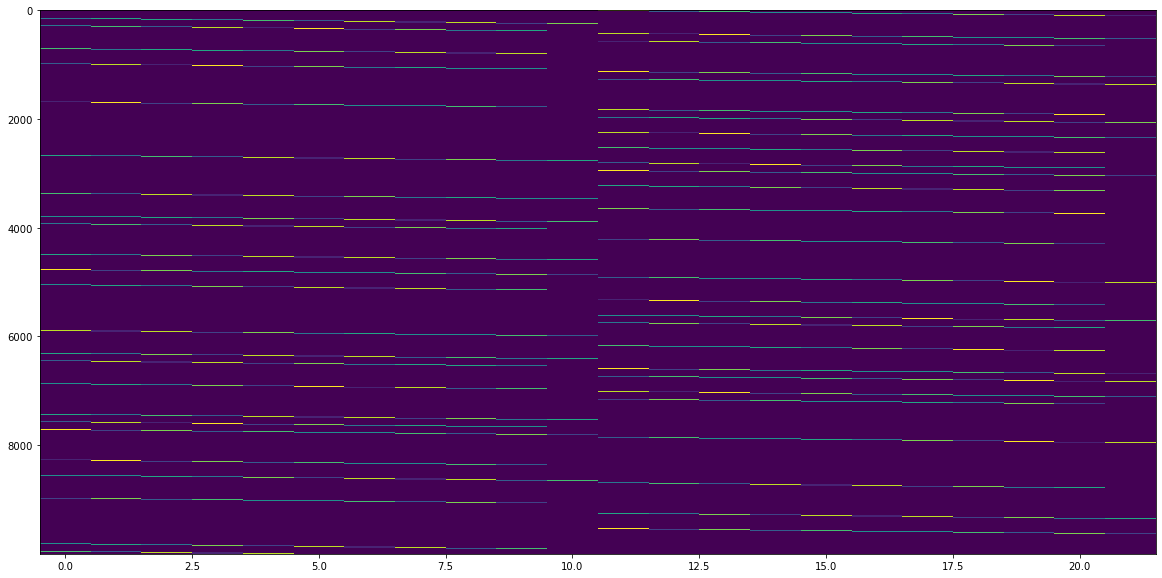

In [38]:
# skip when trcorinc is 0 (zero strength trials)
trcorrect = np.where(trcorinc == 1)[0]
trincorrect = np.where(trcorinc == -1)[0]

correct = []
for tr in trcorrect:
    correct.extend(data.block_inds[tr])
incorrect = []
for tr in trincorrect: incorrect.extend(data.block_inds[tr])

# concatenate these as separate features into a new correct+incorrect design matrix
XadaptCOR = np.zeros(Xadapt.shape)
XadaptINC = np.zeros(Xadapt.shape)

XadaptCOR[correct] = Xadapt[correct]
XadaptINC[incorrect] = Xadapt[incorrect]

XadaptCORINC = np.array([np.hstack((XadaptCOR[t,:],
                                    XadaptINC[t,:])) for t in range(Xadapt.shape[0])])

data.add_covariate("XadaptCORINC", XadaptCORINC)

m.fig()
plt.imshow(XadaptCORINC[:10000], aspect='auto', interpolation='none')
plt.show()

## train the model

Model: M031_N_N_N_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.503451108932495 sec elapsed
Mean LL-Adapt: 0.070922144


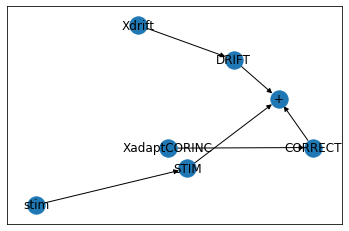

In [39]:
# define the DRIFT network
drift_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, data.Xdrift.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0, # Q: what norm type is this and why should we use it?
    NLtype='lin')
drift_pars['reg_vals'] = {'d2t': 0.2, 'bcs': {'d2t': 0}}
drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[drift_pars])


# define the DIST network
distance_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, XadaptCORINC.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='lin')
distance_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}
distance_net = FFnetwork.ffnet_dict(xstim_n='XadaptCORINC', layer_list=[distance_pars])


# define the STIM network
stim_layer = NDNLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=data.NC,
    bias=False,
    initialize_center=True,
    NLtype='lin')
stim_layer['reg_vals'] = {'d2xt': 0.2, 'bcs':{'d2xt': 1}}
stim_net = FFnetwork.ffnet_dict(xstim_n='stim', layer_list=[stim_layer])


# define the COMBINE network
comb_layer = ChannelLayer.layer_dict(
    num_filters=data.NC,
    NLtype='softplus',
    bias=True)
comb_layer['weights_initializer'] = 'ones'
comb_net = FFnetwork.ffnet_dict(xstim_n=None, ffnet_n=[0, 1, 2], layer_list=[comb_layer], ffnet_type='add')


# define the COMPLETE model
model = NDN.NDN(ffnet_list=[drift_net, distance_net, stim_net, comb_net], loss_type='poisson')


# copy the fit drift weights into this network and freeze them
model.networks[0].layers[0].weight.data = deepcopy(driftw)
model.set_parameters(val=False, name='weight', ffnet_target=0)


# Draw the network
ml.draw_network(model, ['DRIFT', 'CORRECT', 'STIM','+'] )


# Train the complete model
# it automatically uses the train_inds specified in the Dataset object when calling fit()
model.fit(data, force_dict_training=True, **lbfgs_pars, verbose=1)
# Evaluate the complete model
LLsALL = model.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Adapt:", np.mean(LLsDrift - LLsALL))

## look at the weights

<Figure size 432x288 with 0 Axes>

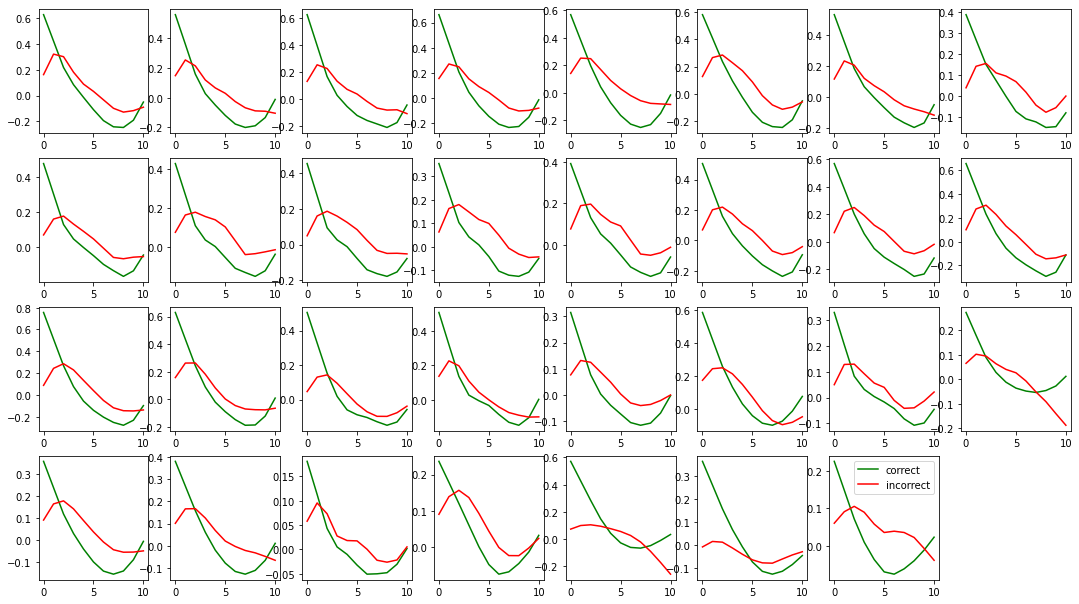

In [40]:
fig = m.fig()
fig.set_size_inches(18.5, 10.5)
for c in range(data.NC):
    plt.subplot(4,8, c+1)
    plt.plot(model.networks[1].layers[0].weight.data[range(0,11), c], 'green', label='correct')
    plt.plot(model.networks[1].layers[0].weight.data[range(11,22), c], 'red', label='incorrect')
plt.legend()
plt.show()

# AUTOENCODER

## train the model

Model: M031_N_N_N_NN_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 41.605042695999146 sec elapsed
Mean LL-Adapt: 0.11803113


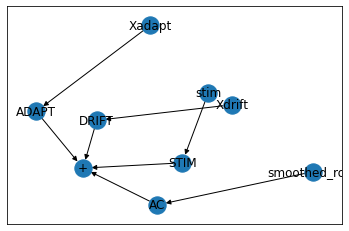

In [58]:
# define the DRIFT network
drift_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, data.Xdrift.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0, # Q: what norm type is this and why should we use it?
    NLtype='lin')
drift_pars['reg_vals'] = {'d2t': 0.2, 'bcs': {'d2t': 0}}
drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[drift_pars])


# define the ADAPT network
adapt_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, Xadapt.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='lin')
adapt_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}
adapt_net = FFnetwork.ffnet_dict(xstim_n='Xadapt', layer_list=[adapt_pars])


# define the STIM network
stim_layer = NDNLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=data.NC,
    bias=False,
    initialize_center=True,
    NLtype='lin')
stim_layer['reg_vals'] = {'d2xt': 0.2, 'bcs':{'d2xt': 1}}
stim_net = FFnetwork.ffnet_dict(xstim_n='stim', layer_list=[stim_layer])


# define the autoencoder network
# input --> LVs (X --> Z)
encoder_layer = NDNLayer.layer_dict(
    # what are these input_dims?
    input_dims=[data.NC, 1, 1, 1], num_filters=3,  # num_LVs --> |Z|
    norm_type=1,  # normalization needed to keep the scale
    # this adjusts the activation threshold by making the output spikes more or less
    bias=False,  # don't put a bias on the input
    NLtype='lin')  # 'lin' -> linear, no nonlinearity applied here
# LVs --> output (Z --> X')
decoder_layer = NDNLayer.layer_dict(
    num_filters=data.NC,
    bias=True, # Q: should we have a bias here? Write out the function.
    NLtype='lin')
# apply L2 regularization on the output
# Q: I don't understand why, though?
decoder_layer['reg_vals'] = {'l2': 0.01}
ac_net = FFnetwork.ffnet_dict(
    xstim_n='smoothed_robs',
    layer_list=[encoder_layer, decoder_layer])


# define the COMBINE network
comb_layer = ChannelLayer.layer_dict(
    num_filters=data.NC,
    NLtype='softplus',
    bias=True)
comb_layer['weights_initializer'] = 'ones'
comb_net = FFnetwork.ffnet_dict(xstim_n=None, ffnet_n=[0, 1, 2, 3], layer_list=[comb_layer], ffnet_type='add')


# define the COMPLETE model
acmodel = NDN.NDN(ffnet_list=[drift_net, adapt_net, stim_net, ac_net, comb_net], loss_type='poisson')

# copy the fit drift weights into this network and freeze them
acmodel.networks[0].layers[0].weight.data = deepcopy(driftw)
acmodel.set_parameters(val=False, name='weight', ffnet_target=0)


# Draw the network
ml.draw_network(acmodel, ['DRIFT', 'ADAPT', 'STIM', 'AC', '+'] )


# Train the complete model
# it automatically uses the train_inds specified in the Dataset object when calling fit()
acmodel.fit(data, force_dict_training=True, **lbfgs_pars, verbose=1)
# Q: are the val_inds setup correctly for validation?
#    yes, the Dataset does this automatically
# Q: are there left out test values to compare with?
#    yes, the Dataset has these, data.test_inds
# Q: should we train the DRIFT and ADAPT models first, and then add them in and not train all at once?
#    just train the DRIFT first and freeze the values, the DRIFT model is the NULL model,
#    b/c we need to account for drift and not just average firing rate
LLsALL = acmodel.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Adapt:", np.mean(LLsDrift - LLsALL))

# Q: Adding in the autoencoder with the robs massively improves the LL,
#    is this because we now are predicting the robs with the robs?
#    The LLs goes up with additional latents,
#    which is expected as we have more parameters to capture the 31 cells activity.

## analyze the latents

In [59]:
redo()
R = ut.construct_R_matrix(data)
Z = ut.construct_Z_matrix(R, acmodel, ac_network=3, num_latents=3)
Z.shape # trials X time X latents

(848, 121, 3)

/tmp/ipykernel_28834/3420112011.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<Figure size 432x288 with 0 Axes>

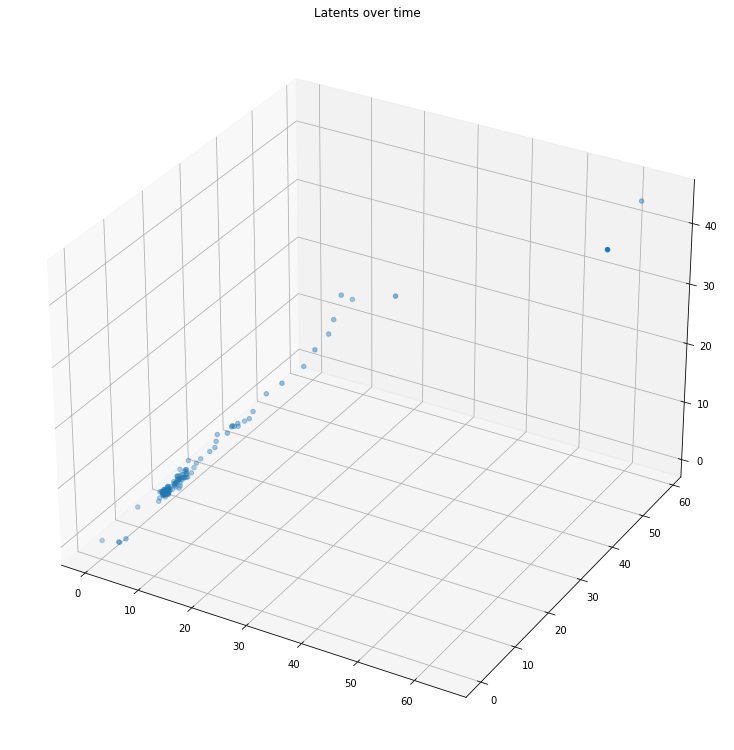

In [68]:
fig = m.fig()
ax = Axes3D(fig)
# average over trials to get the latents over time
ax.scatter(np.mean(Z, axis=0).T[0],
           np.mean(Z, axis=0).T[1],
           np.mean(Z, axis=0).T[2])
plt.title("Latents over time")
plt.show()

<Figure size 432x288 with 0 Axes>

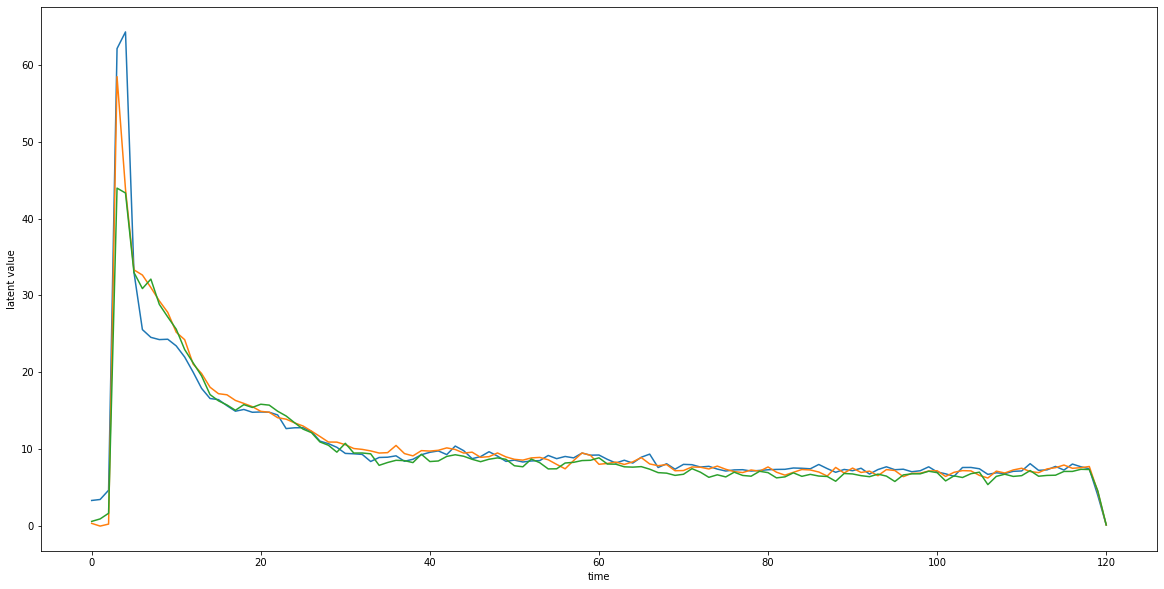

In [72]:
# plot latents averaged over trials
m.fig()
plt.plot(np.mean(Z, axis=0).T[0])
plt.plot(np.mean(Z, axis=0).T[1])
plt.plot(np.mean(Z, axis=0).T[2])
plt.xlabel("time")
plt.ylabel("latent value")
plt.show()

## cued vs. uncued

In [74]:
## 3a find centroids of latents for cued and uncued trials
trcued = np.where(data.TRcued < 0)[0]
truncued = np.where(data.TRcued > 0)[0]
trcued_mean = np.mean(np.mean(Z[trcued], axis=1), axis=0)
truncued_mean = np.mean(np.mean(Z[truncued], axis=1), axis=0)

## 3b calculate vector between the centroids
centroid_vector = trcued_mean - truncued_mean
centroid_vector /= np.sqrt(centroid_vector @ centroid_vector.T)
centroid_vector = np.array([centroid_vector])
print(centroid_vector)

## 3c fit logistic regression model between cued and uncued
# separate cued-uncued points via logistic regression instead of centroids
from sklearn.linear_model import LogisticRegression

cued_trial_model = LogisticRegression(random_state=0).fit(np.mean(Z, axis=1), data.TRcued)

## 3d calculate hyperplane vector
hyperplane_vector = (cued_trial_model.coef_ / np.sqrt(cued_trial_model.coef_ @ cued_trial_model.coef_.T))
print(hyperplane_vector)

[[-0.58852144 -0.56342983 -0.57981837]]
[[ 0.41080634 -0.06926839  0.90908748]]


<Figure size 432x288 with 0 Axes>

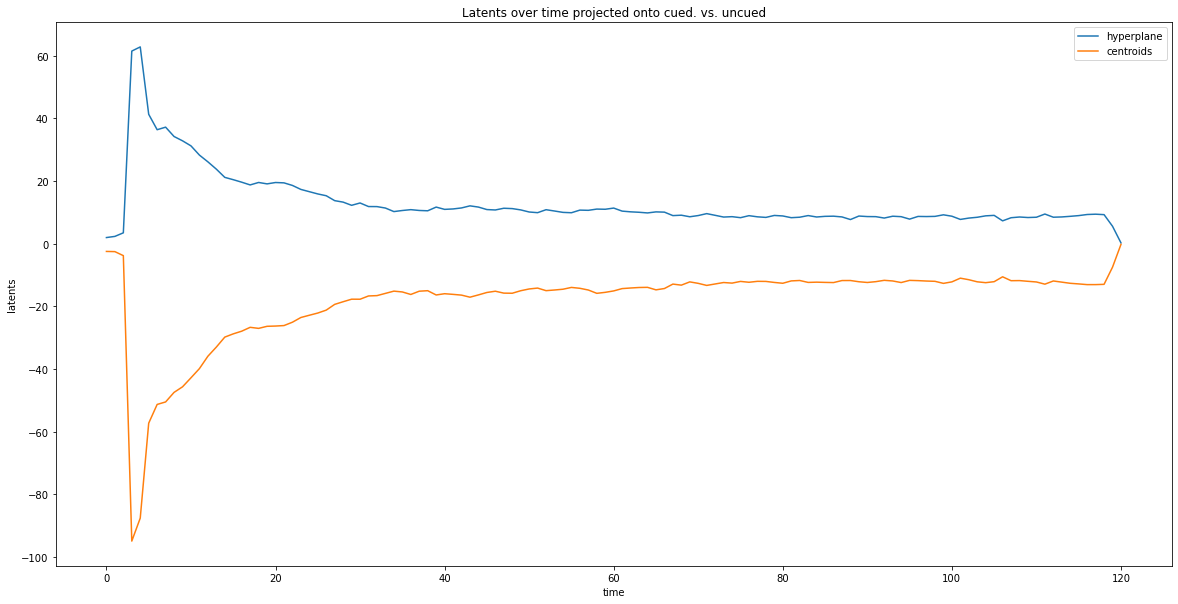

In [76]:
# project the latents over time onto the cued vs. uncued vectors
m.fig()
plt.plot((hyperplane_vector @ np.mean(Z, axis=0).T).T, label="hyperplane")
plt.plot((centroid_vector @ np.mean(Z, axis=0).T).T, label="centroids")
plt.title("Latents over time projected onto cued. vs. uncued")
plt.xlabel("time")
plt.ylabel("latents")
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

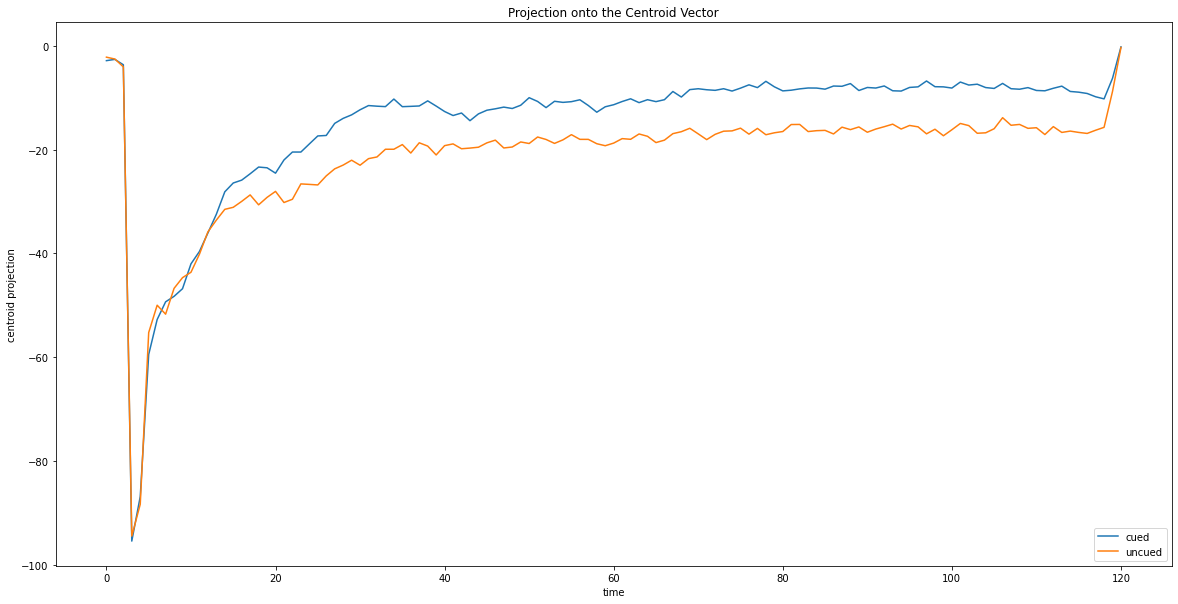

In [80]:
m.fig()
plt.plot((centroid_vector @ np.mean(Z[trcued], axis=0).T).T, label="cued")
plt.plot((centroid_vector @ np.mean(Z[truncued], axis=0).T).T, label="uncued")
plt.legend()
plt.xlabel("time")
plt.ylabel("centroid projection")
plt.title("Projection onto the Centroid Vector")
plt.show()

<Figure size 432x288 with 0 Axes>

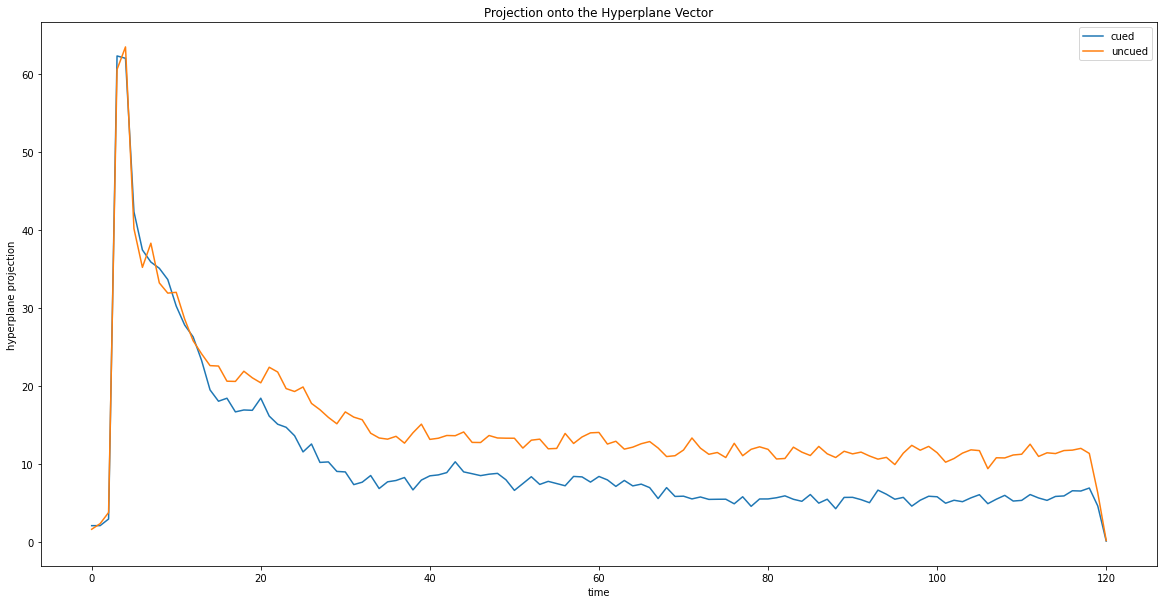

In [78]:
m.fig()
plt.plot((hyperplane_vector @ np.mean(Z[trcued], axis=0).T).T, label="cued")
plt.plot((hyperplane_vector @ np.mean(Z[truncued], axis=0).T).T, label="uncued")
plt.legend()
plt.xlabel("time")
plt.ylabel("hyperplane projection")
plt.title("Projection onto the Hyperplane Vector")
plt.show()

# ---------------------------------------------------------------------------

# Generate the spike train and compare with ground truth (with left-out test set).
------------------ NOTE THIS IS NOTHING RIGHT NOW ------------------

In [42]:
# get the weights for the DRIFT network
driftw = model.networks[0].layers[0].weight.data
data.Xdrift.shape, driftw.shape

(torch.Size([118679, 10]), torch.Size([10, 31]))

In [43]:
model.set_parameters(val=False, name='weight', ffnet_target=3)
model.set_parameters(val=False, name='weight', ffnet_target=0)
model.list_parameters()

Network 0:
  Layer 0:
      NOT FIT: weight: torch.Size([10, 31])
Network 1:
  Layer 0:
      weight: torch.Size([22, 31])
Network 2:
  Layer 0:
      weight: torch.Size([66, 31])
Network 3:
  Layer 0:
      NOT FIT: weight: torch.Size([132, 31])
Network 4:
  Layer 0:
      weight: torch.Size([31, 7])
  Layer 1:
      weight: torch.Size([7, 31])
      bias: torch.Size([31])
Network 5:
  Layer 0:
      weight: torch.Size([1, 31])
      bias: torch.Size([31])


<Figure size 432x288 with 0 Axes>

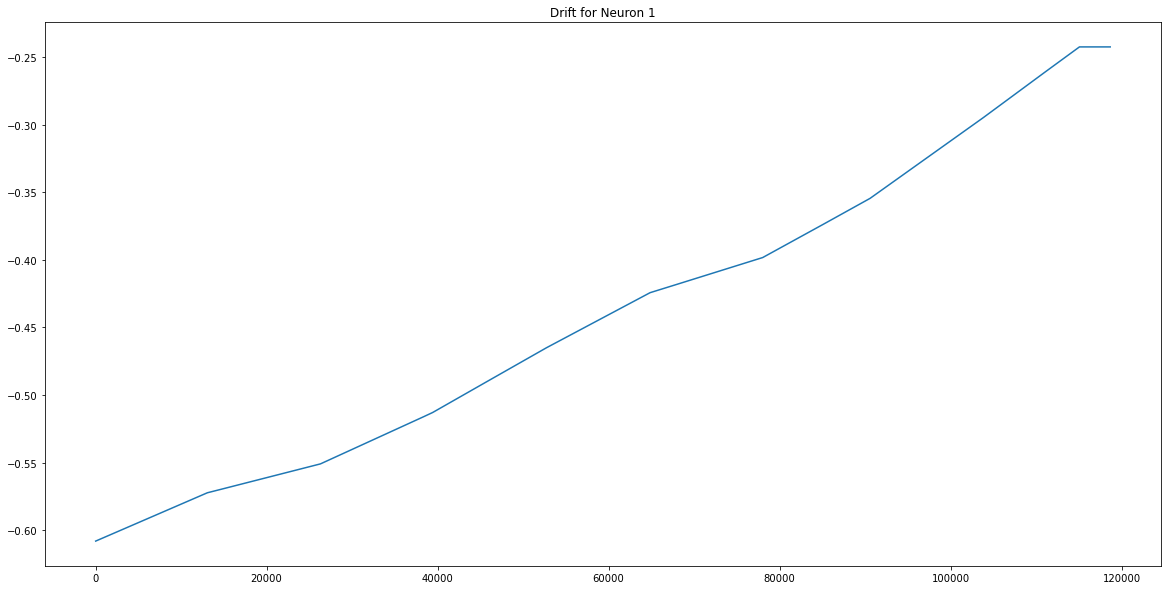

In [44]:
predRs = data.Xdrift @ driftw
m.fig()
plt.plot(predRs[:,0])
plt.title("Drift for Neuron 1")
plt.show()

<Figure size 432x288 with 0 Axes>

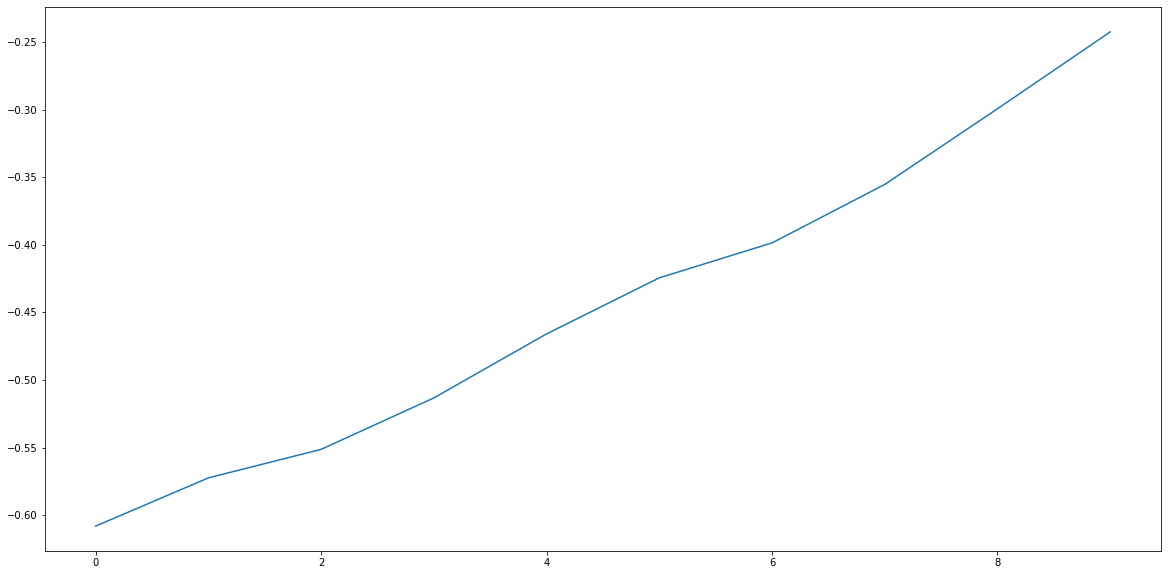

In [45]:
m.fig()
plt.plot(driftw.numpy()[:,0])
plt.show()

torch.Size([22, 31])


<Figure size 432x288 with 0 Axes>

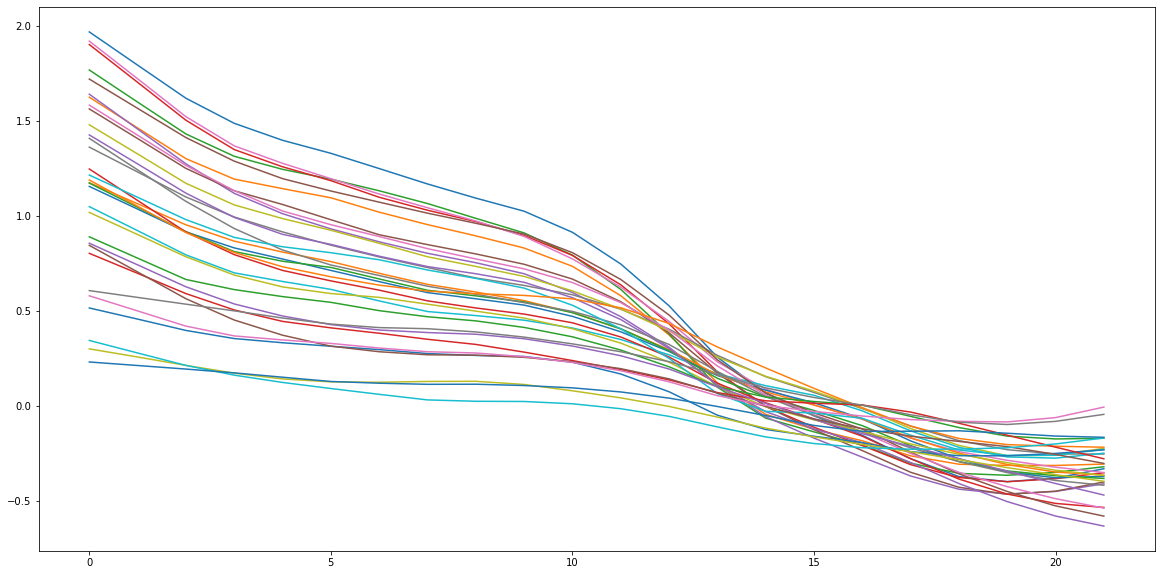

In [46]:
adaptw = model.networks[1].layers[0].weight.data
print(adaptw.shape)
m.fig()
plt.plot(adaptw.numpy())
plt.show()

In [47]:
stimw = model.networks[2].layers[0].weight.data
data.stim.shape, stimw.shape, data.robs.shape

(torch.Size([118679, 132]), torch.Size([66, 31]), torch.Size([118679, 31]))

In [48]:
predRs = data.stim @ stimw
m.fig()
plt.plot(predRs[:,0][:100])
plt.plot(data.robs[:,0][:100])
plt.title("Firing Rate for Neuron 1")
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (118679x132 and 66x31)

In [ ]:
# TODO: combine cued/uncued with multiplication in its own network -- Does Attentional Gain affect firing in an additive or multiplicate way?
#       and compare accuracy with addition